<a href="https://colab.research.google.com/github/Parishri07/Learning-PyTorch/blob/main/Transfer_Learning_on_FoodVision_Mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What is transfer learning?

Transfer learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem.

Pretrained model = foundation models

In [23]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu121
0.18.1+cu121


In [24]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [25]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Get data

In [26]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from the Food101 dataset

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download.")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists, skipping re-download.


In [27]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

**Create Datasets and DataLoaders**

Now we've got some data, want to turn it into PyTorch DataLoaders.

To do so, we can use data_setup.py and the create_dataloaders() function we made in 05. PyTorch Going Modular.

There's one thing we have to think about when loading: how to transform it?

And with torchvision 0.13+ there's two ways to do this:

Manually created transforms - you define what transforms you want your data to go through.
Automatically created transforms - the transforms for your data are defined by the model you'd like to use.
Important point: when using a pretrained model, it's important that the data (including your custom data) that you pass through it is transformed in the same way that the data the model was trained on.

**Creating a transform for torchvision.models (manual creation)**

torchvision.models contains pretrained models (models ready for transfer learning) right within torchvision.

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize.

In [28]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
                                        transforms.Resize((224, 224)), # resize image to 224, 224 (height x width)
                                        transforms.ToTensor(), # get images into range [0, 1]
                                        normalize]) # make sure images have the same distribution as ImageNet (where our pretrained models have been trained)

In [29]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ac334f53010>,
 ['pizza', 'steak', 'sushi'])

**Creating a transform for torchvision.models (auto creation)**

In [30]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [31]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [32]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ac334f51f30>,
 ['pizza', 'steak', 'sushi'])

**Getting a pretrained model**

There are various places to get a pretrained model, such as:

1. PyTorch domain libraries
2. Libraries like timm (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

**Which pretrained model should you use?**

Three things to consider:

1. Speed - how fast does it need to run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem (e.g. how well does it classify food images? for FoodVision Mini)?

Where does the model live?

Is it on device? (like a self-driving car)

Or does it live on a server?

Looking at https://pytorch.org/vision/main/models.html#table-of-all-available-classification-weights

Which model should we chose?

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of our best options in terms performance vs size.

However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could - http://www.incompleteideas.net/IncIdeas/BitterLesson.html

**Setting up a pretrained model**

In [33]:
# OLD method of creating a pretrained model (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # ".DEFAULT" = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [34]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [35]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [36]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

**Getting a summary of our model with torchinfo.summary()**

In [37]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

**Freezing the base model and changing the output layer to suit our needs**

With a feature extractor model, typically you will "freeze" the base layers of a pretrained/foundation model and update the output layers to suit your own problem.

In [38]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False

In [39]:
len(class_names)

3

In [40]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # feature vector coming in
              out_features=len(class_names))).to(device) # how many classes do we have?

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [41]:
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

**Train model**

In [42]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [43]:
# Import train function
from going_modular.going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
[INFO] Total training time: 172.397 seconds


**Evalaute model by plotting loss curves**

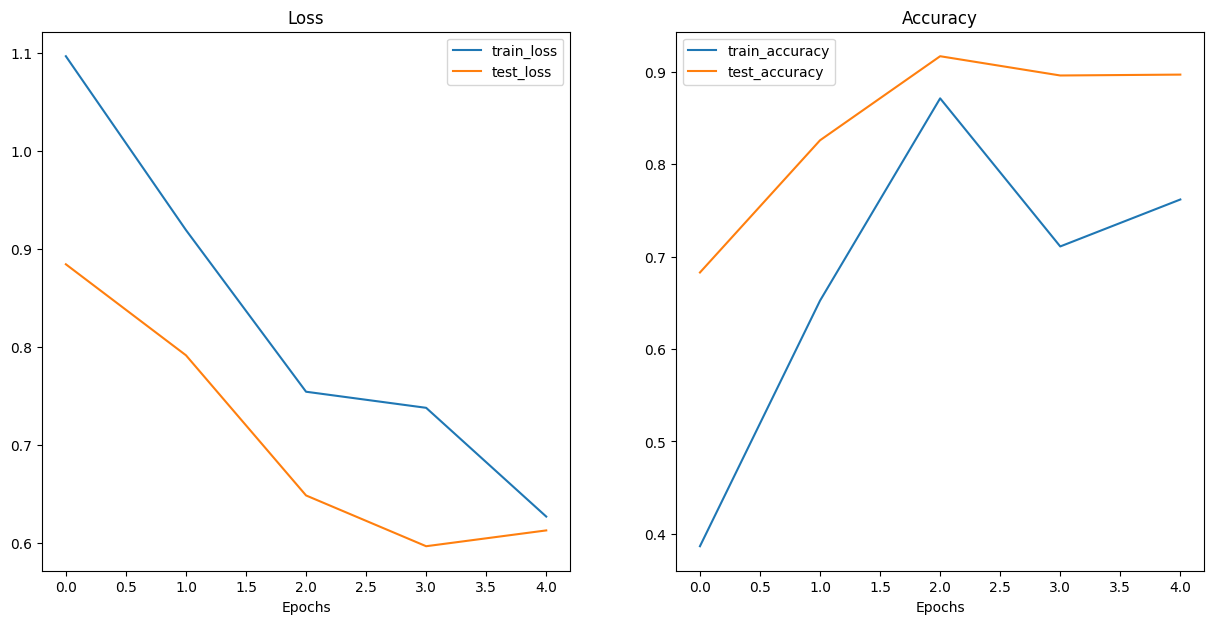

In [44]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

**Make predictions on images from the test set**

We have to make sure that our test/custom data is:

Same shape - images need to be same shape as model was trained on

Same datatype - custom data should be in the same data type

Same device - custom data/test data should be on the same device as the model

Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same

To do all of this automagically, let's create a function called pred_and_plot_image():

The function will be similar to the one here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device
2. pen the image with PIL.Image.Open()
3. Create a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to model.eval() mode to make sure it's ready for inference (this will turn off things like nn.Dropout())
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using torch.softmax()
9. Convert model's prediction probabilities to prediction labels using torch.argmax()
10. Plot the image with matplotlib and set the title to the prediction label from step 9 and prediction probability from step 8

In [45]:
from typing import List, Tuple

from PIL import Image

from torchvision import transforms

# 1. Take in a trained model...
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # 2. Open the image with PIL
  img = Image.open(image_path)

  # 3. Create a transform if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
                                          transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])
    ])

  ### Predict on image ###
  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_size, color_channels, height, width]

    # 7. Make a prediction on the transformed image by passing it to the model (also ensure it's on the target device)
    target_image_pred = model(transformed_image.to(device))

  # 8. Convert the model's output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  # print(target_image_pred_probs.max())

  # 9. Convert the model's pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10. Plot image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

In [46]:
test_dir

PosixPath('data/pizza_steak_sushi/test')

In [47]:
class_names

['pizza', 'steak', 'sushi']

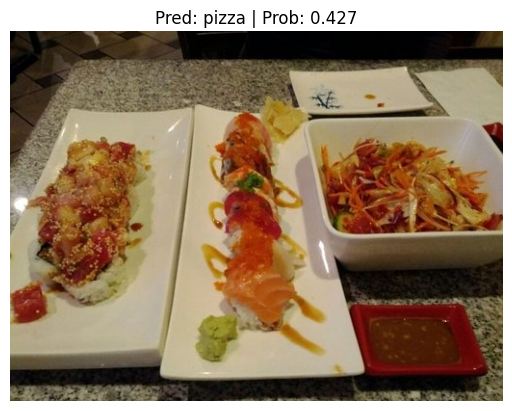

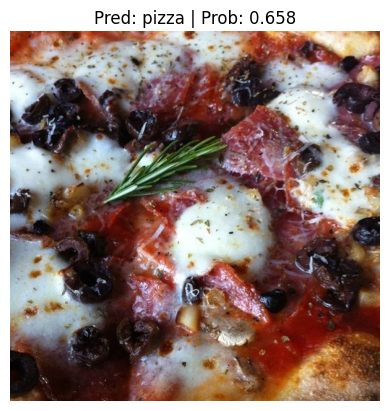

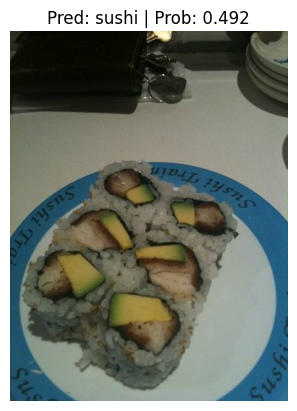

In [48]:
# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

**Making predictions on a custom image**

In [49]:
# Download the image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # Download image from GitHub with "raw" link
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
    print(f"Download {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

Download data/04-pizza-dad.jpeg...


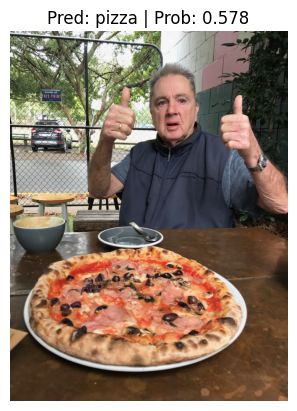

In [50]:
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)